# 'On the fly' Data assimilation on HBV model using particle filtering

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
from tqdm import tqdm
from rich import print

In [2]:
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

Ensure the HBV model is loaded and the Data Assimilation model is present:

```py
 pip install ewatercycle-HBV
 pip install ewatercycle-DA
```

#### set up paths

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
for path in [forcing_path, observations_path, figure_path, output_path]:
    path.mkdir(exist_ok=True)

#### add parameter info

In [4]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5, 0])
## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]
par_0 = (p_min_initial + p_max_initial)/2 # set initial as mean of max,min

In [5]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-09-01T00:00:00Z"
alpha = 1.26

In [6]:
from ewatercycle.forcing import sources

The test forcing shown here is availible from [github.com/Daafip/ewatercycle-hbv](https://github.com/Daafip/ewatercycle-hbv/blob/main/tests/files/test_forcing.txt) 

In [7]:
test_forcing = sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'test_forcing.txt',
                          test_data_bool = True 
                          )

#### import model

In [8]:
from ewatercycle.models import HBV

#### import DA function:

In [9]:
from ewatercycle_DA import DA

In [10]:
n_particles = 50

In [11]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [12]:
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [13]:
# values wihch you 
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'parameters':','.join([str(p) for p in p_intial[index]]), 
                            'initial_storage':','.join([str(s) for s in s_0]),
                             })

In [14]:
# this initializes the models for all ensemble members. 
ensemble.initialize(model_name=["HBV"]*n_particles,
                    forcing=[test_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst) 

## Import observations

In [15]:
# create a reference model
ref_model = ensemble.ensemble_list[0].model

In [16]:
# testing data 
ds_obs_dir = forcing_path / ref_model.forcing.pr
ds_obs = xr.load_dataset(ds_obs_dir)

In [17]:
units = {}
var_names = param_names + stor_names + ['Q']
for var in var_names:
    units.update({var: ref_model.bmi.get_var_units(var)})

## setup DA

This sets up all the require data assimilation information

In [18]:
def H(Z):
    if len(Z) == 15:
        return Z[-1] 
    else: 
        raise SyntaxWarning(f"Length of statevector should be 9 but is {len(Z)}")

## Run

### First half without assimilating:

In [19]:
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)
half_n_timesteps = int(n_timesteps/2)
lst_Q = [] 
time = []
for _ in tqdm(range(half_n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    ensemble.update(assimilate=False)
    lst_Q.append(ensemble.get_value("Q").flatten())
    # TODO: adjust so that tLag ? currently still often 3

100%|█████████████████████████████████████████| 563/563 [00:30<00:00, 18.49it/s]


### Then second half with

In [20]:
ensemble_method_name = "PF"
lst_like_sigma = [0.0075] * 14 + [0]
hyper_parameters = {
               'like_sigma_weights' : 0.005,
               'like_sigma_state_vector' : lst_like_sigma,
               'f_n_particles': 1,
                 }

state_vector_variables = "all"
measurement_operator = H

In [21]:
lst_state_vector = []
for _ in tqdm(range(half_n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    ensemble.update(assimilate=False)
    ensemble.assimilate(ensemble_method_name = ensemble_method_name,
                    obs = ds_obs["Q"].sel(time=time[-1]).values,
                    measurement_operator = measurement_operator,
                    hyper_parameters = hyper_parameters,
                    state_vector_variables = state_vector_variables)

    lst_state_vector.append(ensemble.get_state_vector())
    lst_Q.append(ensemble.get_value("Q").flatten())
ensemble.finalize() # end model - IMPORTANT! when working with dockers

100%|█████████████████████████████████████████| 563/563 [08:36<00:00,  1.09it/s]


### process the numpy data into easily acessed data types

In [22]:
Q_m_arr = np.array(lst_Q).T
state_vector_arr = np.array(lst_state_vector)
state_vector_arr_copy = state_vector_arr.copy()

In [23]:
df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

### process states and parameters into xarrys

In [24]:
empty_state_vector = []
for _ in range(half_n_timesteps):    
    arr = np.zeros((state_vector_arr.shape[1],state_vector_arr.shape[2]))
    arr[:,:] = np.nan
    empty_state_vector.append(arr)
empty_state_vector_arr = np.hstack(empty_state_vector).reshape(half_n_timesteps,state_vector_arr.shape[1],state_vector_arr.shape[2])
state_vector_arr = np.vstack([empty_state_vector_arr, state_vector_arr_copy])

In [25]:
data_vars = {}
for i, name in enumerate(param_names + stor_names):
    storage_terms_i = xr.DataArray(state_vector_arr[:,:,i].T,
                                   name=name,
                                   dims=["EnsembleMember","time"],
                                  coords=[np.arange(n_particles),df_ensemble.index],
                                  attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                           "history": f"Storage term results from ewatercycle_HBV.model",
                                        "description":"Moddeled values",
                                             "units": "mm"})
    data_vars[name] = storage_terms_i

ds_combined = xr.Dataset(data_vars,
                         attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                "history": f"Storage term results from ewatercycle_HBV.model",}
                          )

In [26]:
save = False
if save:
    ds_combined.to_netcdf(output_path / f'combined_ds_{current_time}.nc')

## Plotting

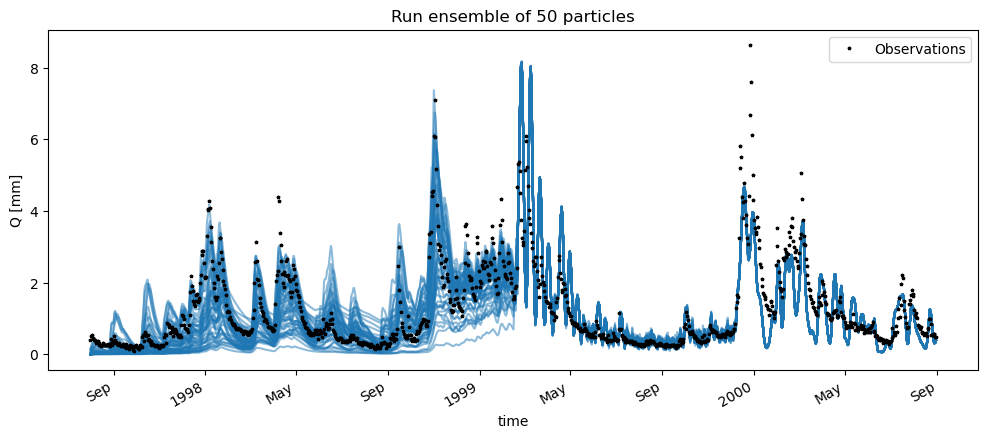

In [27]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax.legend(bbox_to_anchor=(1,1))
df_ensemble.plot(ax=ax,alpha=0.5,zorder=-1,legend=False,color="C0")
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png")

Can calculate the NSE

In [28]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [29]:
mean_ensemble = df_ensemble.T.mean()
NSE_mean_ens = calc_NSE(ds_obs['Q'].sel(time=time).values,mean_ensemble.loc[time])

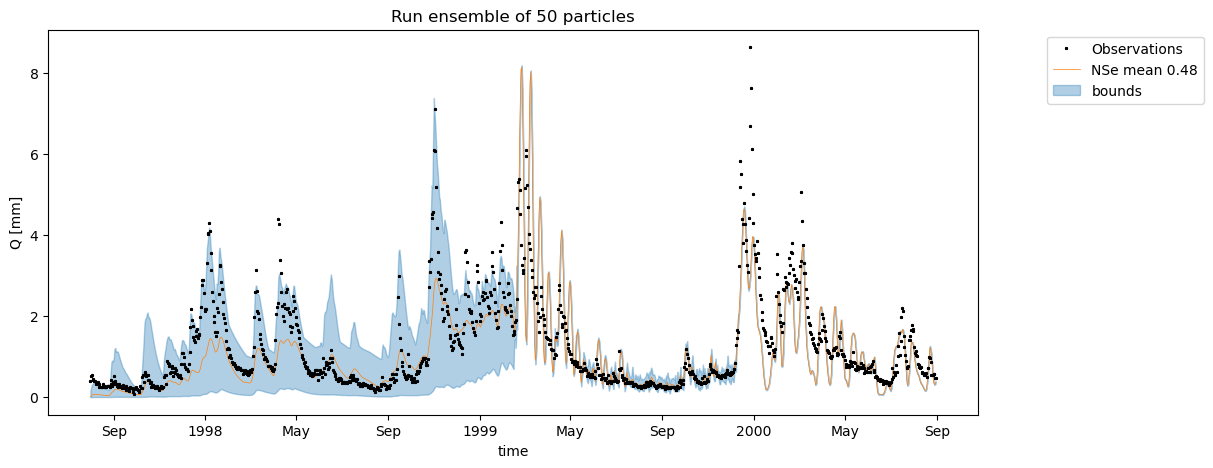

In [30]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"NSe mean {NSE_mean_ens:.2f}",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png",bbox_inches="tight",dpi=400);

Here we see the transition half way through from running an ensemble of models to applying data assimilation. 
In the newest version of the eWaterCyclce-Da is it possible to retrieve the model state before assimilating, this is an older notebook thus doesn't include this aspect. 

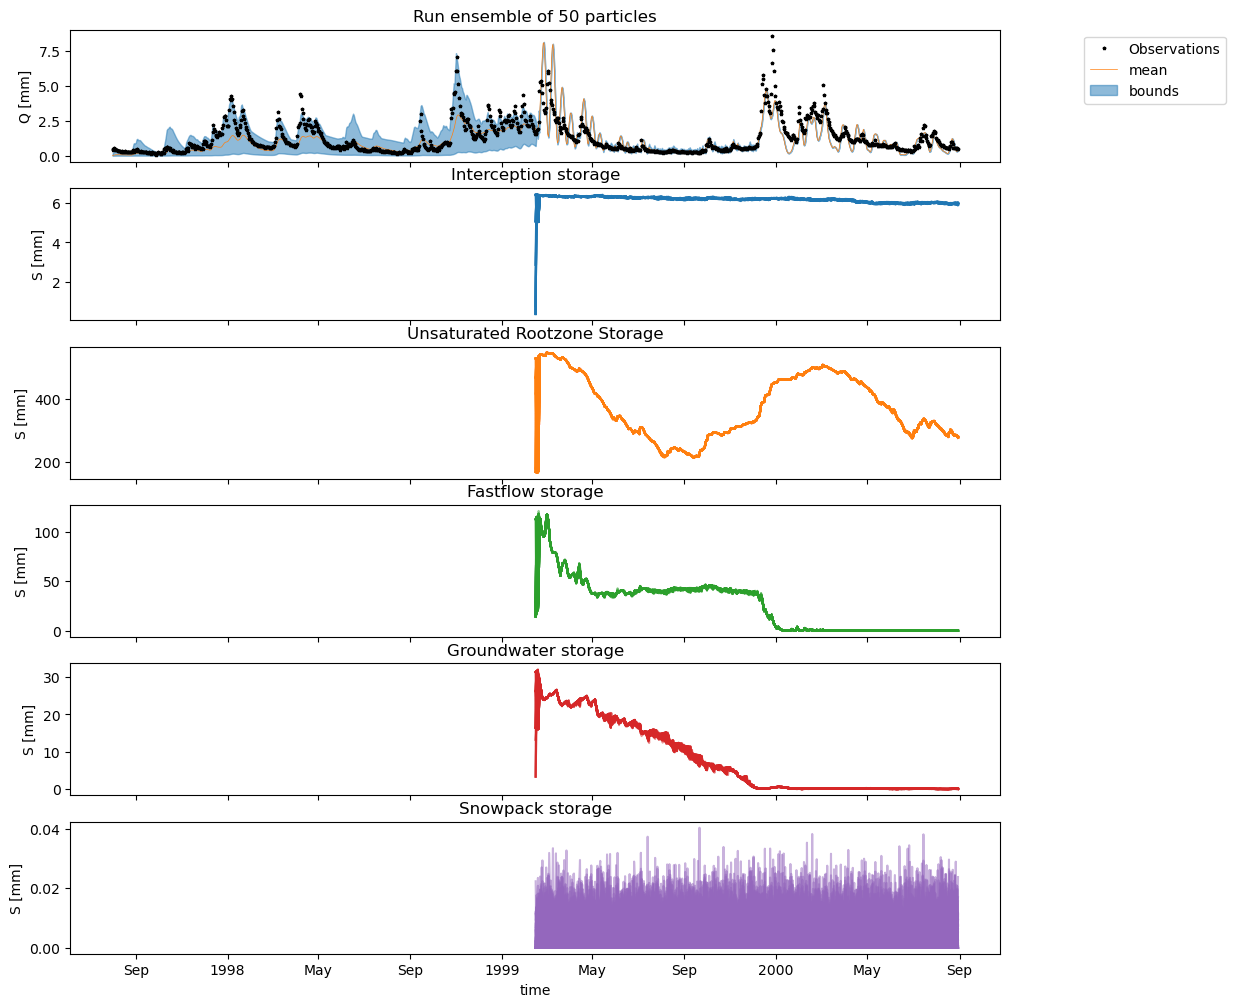

In [31]:
n=6
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)
ax = axs[0]
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
for i, S_name in enumerate(S_names):
    for j in range(n_particles):
        ds_combined[stor_names[i]].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(S_name)
[ax.set_xlabel(None) for ax in axs[:-1]]# remove all unncecearry xlabels
[ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)

In [32]:
param_names_0 = param_names[:4]
param_names_1 = param_names[4:]

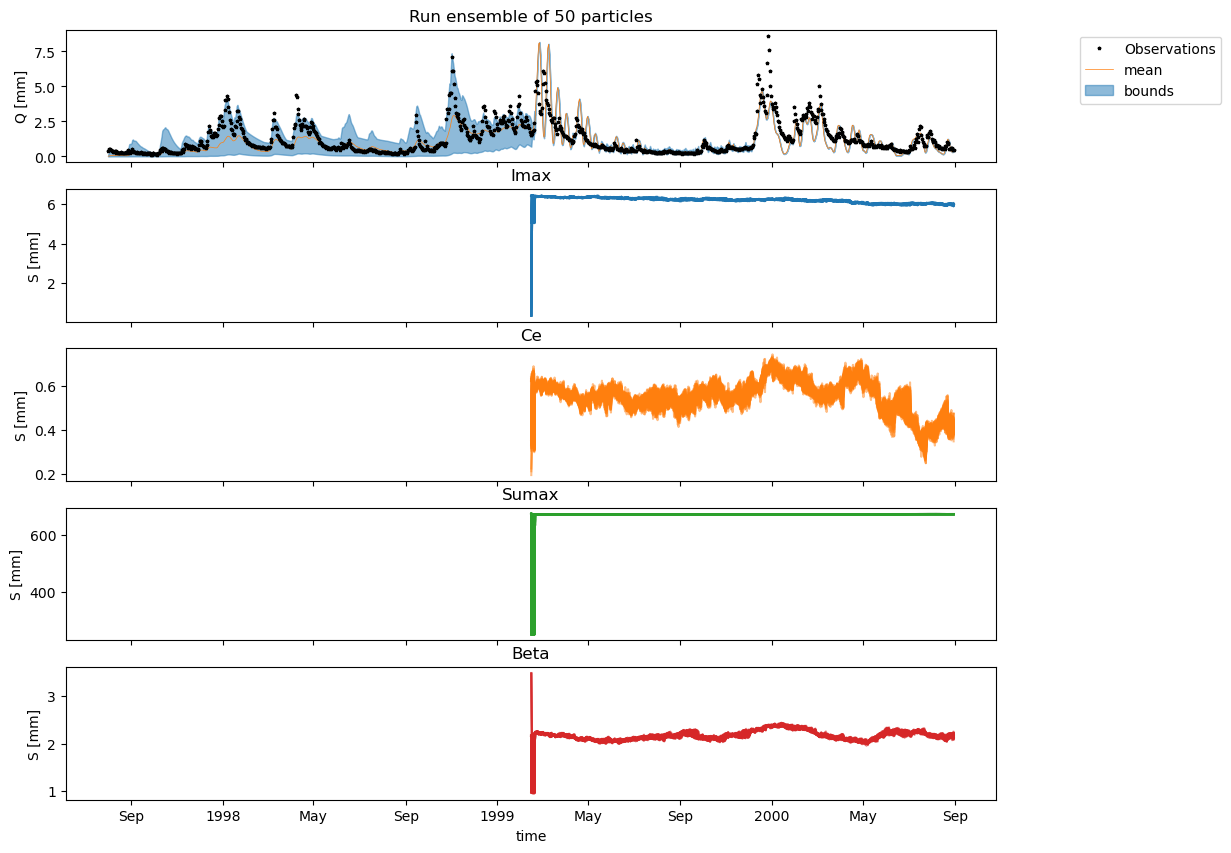

In [33]:
n=5
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)
ax = axs[0]
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
for i, parameter in enumerate(param_names_0):
    for j in range(n_particles):
        ds_combined[parameter].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(parameter)

[ax.set_xlabel(None) for ax in axs[:-1]]
[ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)

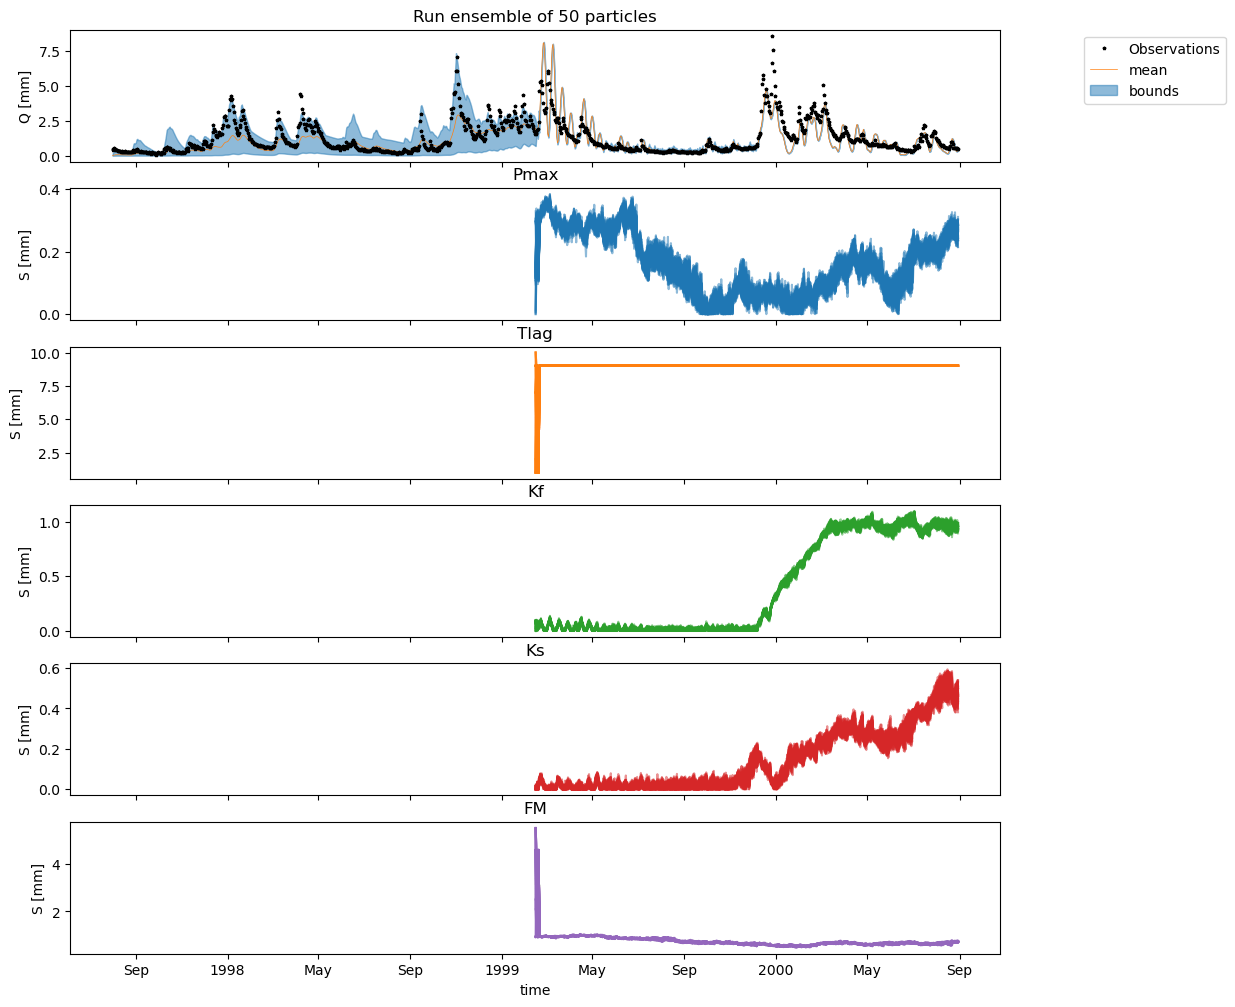

In [34]:
n=6
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)
ax = axs[0]
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
for i, parameter in enumerate(param_names_1):
    for j in range(n_particles):
        ds_combined[parameter].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(parameter)

[ax.set_xlabel(None) for ax in axs[:-1]]
[ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)